In [74]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SentimentAnalysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SentimentAnalysis


### Install and import libraries

In [75]:
!pip install pyvi

In [76]:
!pip install underthesea

In [77]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load datasets

In [78]:
data_train = pd.read_csv("datasets/vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("datasets/vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [79]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [80]:
data_train.sample(10)

,Class,Data
2782,1,mình ko bik con loa bạn đang dùng nên ko đánh ...
2971,1,Ồh một thay đổi lớn làm thay đổi thế giới đây!...
3270,1,Quá đẹp và chất với mức giá.Đã dùng qua Mi4 và...
24,-1,Ko thể cài thêm game mới là ko ổn rồi.
2729,1,1 vote cho Fuji. Mirolless Fuji làm tốt thật.
3404,0,chuột bluetooth toàn tiền triệu hông vậy nè
1694,-1,"Không biết mọi người dùng thế nào, riêng tôi:-..."
367,-1,Vĩnh biệt Oppo
2082,1,"Nhìn em Iphone iu gì đâu á, mấy em còn lại khô..."
4631,0,"Bạn không nói rõ giá bao nhieu?, nhưng nếu thậ..."


<Axes: >

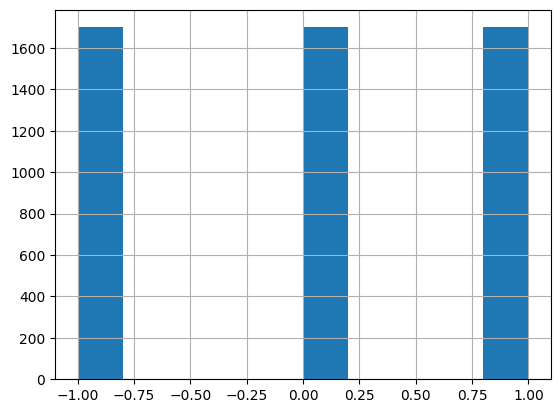

In [81]:
data_train['Class'].hist()

### Preprocess

In [82]:
def encode_label(labels):
  encoded_labels = []

  for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

  return np.array(encoded_labels)

encoded_labels = encode_label(data_train['Class'].values)
encoded_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [83]:
# Normalize text using Underthesea
from underthesea import text_normalize

def normalize(text):
  return text_normalize(text)

# text = "Không nên mua chuột cua Logitech, vì dùng nó rất khó đổi cái mới. Mình nghe thằng bạn xúi mua con M325 cách đây 5 năm, dù có cơ số lần rơi rớt quăng quật mà đến giờ vẫn chưa hư. Giờ đang thèm em MX Anywhere 2 này mà chuột cũ chưa hư sao mua chuột mới!"
# print(normalize(text))

In [84]:
# Remove url
import re

def remove_urls(text):
    url_pattern = re.compile(r'(http|https)://[^\s]+')
    cleaned_text = re.sub(url_pattern, '', text)

    return cleaned_text

In [85]:
# Remove digits
from string import digits

def remove_digits(text):
    cleaned_text = ''.join([char for char in text if char not in digits])
    return cleaned_text

In [86]:
# Remove duplicate punctuation
def remove_dup_punctuation(text):
  text.replace('...', '')
  cleaned_text = re.sub(r'([^\w\s])\1+', r'\1', text)

  return cleaned_text

In [87]:
# Remove duplicate
def remove_dup_char(text):
  text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE)
  text = re.sub(r'([a-z][a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE)

  return text

In [88]:
# Use PyVi for Vietnamese word tokenizer
from pyvi import ViTokenizer

def tokenize(text):
  text = ViTokenizer.tokenize(text.lower())
  return text.split(' ')

In [109]:
# Combine all processing
def preprocess(text):
  text = normalize(text)
  text = remove_urls(text)
  text = remove_digits(text)
  text = remove_dup_punctuation(text)
  text = remove_dup_char(text)
  tokens = tokenize(text)

  return tokens

In [132]:
text = "Xài đi rồi thấy cảnh, phụ kiện rất đắt đỏ."
print(preprocess(text))

['xài', 'đi', 'rồi', 'thấy', 'cảnh', ',', 'phụ_kiện', 'rất', 'đắt_đỏ', '.']


In [133]:
from random import randint

INDEX = randint(0, len(data_train['Data']))
print(data_train['Data'].tolist()[INDEX], sep="")
print(data_train['Processed_data'].to_list()[INDEX], sep="")

kiếm cái logo táo dán lên mặt sau nữa là y chang luôn !
['kiếm', 'cái', 'logo', 'táo', 'dán', 'lên_mặt', 'sau', 'nữa', 'là', 'y', 'chang', 'luôn', '!']


In [112]:
word_reviews = data_train['Processed_data'].to_list()

In [113]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [114]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [115]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [116]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [117]:
print('Shape of X train and validation:', data.shape)
print('Shape of label train and validation:', labels.shape)

Shape of X train and validation: (5100, 300)
Shape of label train and validation: (5100, 3)


### Embedding using Word2Vec

In [118]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('models/vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("Vocabulary size:", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

Vocabulary size: 7750


### Define and train model

In [119]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPooling1D(64, strides=1)(conv_0)
conv_1 = MaxPooling1D(64, strides=1)(conv_1)
conv_2 = MaxPooling1D(64, strides=1)(conv_2)

# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_1 = LSTM(256,return_sequences=True)(concat)
lstm_0 = LSTM(128, dropout=drop, recurrent_dropout=drop)(lstm_1)

# ############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes input and output
model = Model(inputs, output)

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 300, 400)             3100000   ['input_7[0][0]']             
                                                                                                  
 reshape_24 (Reshape)        (None, 300, 400)             0         ['embedding_3[0][0]']         
                                                                                                  
 conv1d_18 (Conv1D)          (None, 300, 100)             120100    ['reshape_24[0][0]']          
                                                                                            

In [120]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 [==============================] - 30s 1s/step - loss: 4.8994 - accuracy: 0.4627 - val_loss: 4.3472 - val_accuracy: 0.0000e+00
Epoch 2/10
16/16 [==============================] - 22s 1s/step - loss: 2.9611 - accuracy: 0.5659 - val_loss: 2.9929 - val_accuracy: 0.0000e+00
Epoch 3/10
16/16 [==============================] - 23s 1s/step - loss: 1.8969 - accuracy: 0.6564 - val_loss: 2.2440 - val_accuracy: 0.0000e+00
Epoch 4/10
16/16 [==============================] - 23s 1s/step - loss: 1.3794 - accuracy: 0.7108 - val_loss: 2.3182 - val_accuracy: 0.0392
Epoch 5/10
16/16 [==============================] - 23s 1s/step - loss: 1.1941 - accuracy: 0.7216 - val_loss: 2.8071 - val_accuracy: 0.0000e+00
Epoch 6/10
16/16 [==============================] - 23s 1s/step - loss: 0.9778 - accuracy: 0.7971 - val_loss: 1.9730 - val_accuracy: 0.3049
Epoch 7/10
16/16 [==============================] - 22s 1s/step - loss: 0.7472 - accuracy: 0.8762 - val_loss: 2.0110 - val_accuracy: 0.3931
Epoc

### Predict and evaluate results

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def calculate_metrics(X_test_scaled, Y_test,model = None):
    # Get model predictions
    if model:
       y_predict_r = model.predict(X_test_scaled)
    else:
       y_predict_r = X_test_scaled
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r, average='macro')
    rec = recall_score(Y_test, y_predict_r, average='macro')
    f1 = f1_score(Y_test, y_predict_r, average='macro')

    return acc, prec, rec, f1

def get_metrics(X_test, Y_test, model = None):
    acc, prec, rec, f1 = calculate_metrics(X_test, Y_test, model = model)
    display_df = pd.DataFrame([[acc, prec, rec, f1]], columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return display_df

In [122]:
sequences_test = tokenizer.texts_to_sequences(data_test['Processed_data'].to_list())
word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encode_label(data_test['Class'].values)

In [123]:
print('Shape of X test:', word_reviews_test.shape)
print('Shape of label test:', labels_test.shape)

Shape of X test: (1050, 300)
Shape of label test: (1050, 3)


In [124]:
inference = model.predict(word_reviews_test)

33/33 [==============================] - 3s 71ms/step


In [125]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

df = get_metrics(y_hat, y, model = None)
df.index = ['CNN+LSTM']
df.head(10)

,Accuracy,Precision,Recall,F1 Score
CNN+LSTM,0.56,0.654861,0.56,0.495941


Text(0.5, 3.722222222222216, 'Predicted')

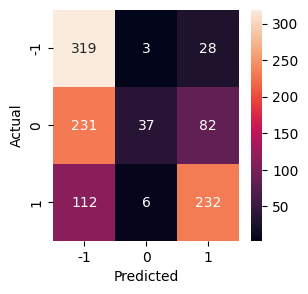

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(3, 3))
conf_mat = confusion_matrix(y, y_hat)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [127]:
model.save_weights("CNN+LSTM.h5")
!cp CNN+LSTM.h5 /content/drive/MyDrive/SentimentAnalysis/models